In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from hydra import initialize, compose

import time

import torch
from torch import optim

from bliss.models import encoder, decoder
from bliss.models.encoder import get_star_bool
from bliss.datasets import simulated

import sys
sys.path.insert(0, './utils/')
import plotting_utils 
import flux_encoder_lib
from flux_loss_lib import kl_qp_flux_loss


from which_device import device
print(device)


# _ = torch.manual_seed(34)


cuda:4


# Load dataset

In [2]:
overrides = {'model':"sleep_sdss_measure_simple", 'dataset':'default'}
overrides = [f"{key}={value}" for key, value in overrides.items()]
with initialize(config_path="../../config"): # possibly change relative path to config folder here. 
    cfg = compose("config", overrides=overrides)

In [3]:
# overwriting some values 
cfg.dataset.kwargs.update({'generate_device': device, 
                           'n_batches': 100})


cfg.model.kwargs.decoder_kwargs.update({'prob_galaxy': 0.})

In [4]:
dataset = simulated.SimulatedDataset(**cfg.dataset.kwargs)

# save some constants we will use later
slen = dataset.image_decoder.slen
n_bands = dataset.image_decoder.n_bands

tile_slen = dataset.image_decoder.tile_slen
ptile_slen = dataset.image_decoder.ptile_slen

batch_size = dataset.batch_size
border_padding = dataset.image_decoder.border_padding
max_sources = dataset.image_decoder.max_sources

# we will need the decoder later for the loss as well 
image_decoder = dataset.image_decoder
image_decoder.requires_grad_(False);

### The data loaders

In [5]:
train_dataloader = dataset.train_dataloader()
test_dataloader = dataset.test_dataloader()

### some sample images

In [6]:
for _, batch in enumerate(train_dataloader):
    break

In [7]:
_true_tile_dict = dict(locs = batch['locs'],
                       n_sources = batch['n_sources'],
                       galaxy_bool = batch['galaxy_bool'])
    
true_params = encoder.get_full_params(_true_tile_dict, dataset.image_decoder.slen)

In [8]:
def plot_params(params, indx, ax): 
    locs = params['locs'][indx].cpu() * slen + border_padding
    locs = locs[:, (1, 0)]

    n_sources = int(params['n_sources'][indx])
    galaxy_bool = params['galaxy_bool'][indx].squeeze().cpu()    
    
    plotting_utils.plot_locations(locs, 
                                  galaxy_bool, 
                                  n = n_sources, 
                                  ax = ax)

In [9]:
%matplotlib inline

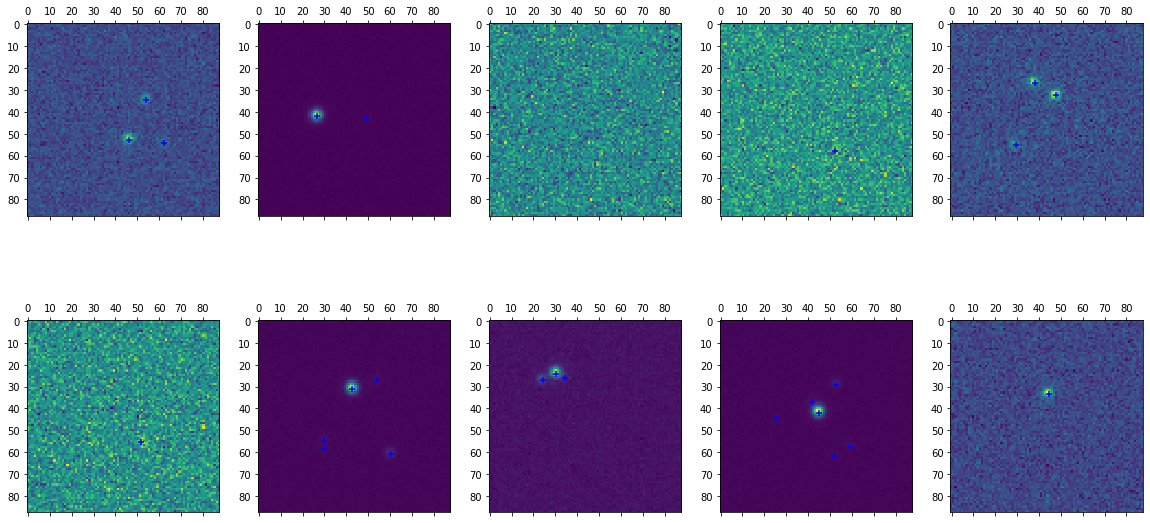

In [10]:
fig, axes = plt.subplots(2, 5, figsize=(20,10))

for indx in range(10): 
    
    i0 = indx // 5
    i1 = indx % 5
    axes[i0, i1].matshow(batch['images'][indx, 0].cpu())

    plot_params(true_params, indx, axes[i0, i1])

# Define encoder

In [11]:
flux_encoder = flux_encoder_lib.MLPEncoder(ptile_slen = ptile_slen, 
                                           tile_slen = tile_slen,
                                           n_bands = n_bands,
                                           max_sources = max_sources).to(device)

# Define loss

In [12]:
def get_loss(batch): 
    
    # get estimates
    out = flux_encoder(batch['images'])
    
    # get loss
    kl, neg_ll, recon = kl_qp_flux_loss(image_decoder, 
                                  batch,
                                  out['samples'], 
                                  out['sd'])
        
    return kl.mean(), neg_ll.mean()

### This is the log-likelihood under the true parameters 

In [13]:
_, neg_ll, _ = \
    kl_qp_flux_loss(image_decoder, 
                    batch,
                    batch['fluxes'], 
                    # set the sd to 1
                    batch['fluxes'] * 0. + 1.0)

print('negative loglikelihood (truth): ', neg_ll.mean())

negative loglikelihood (truth):  tensor(37219.5703, device='cuda:4')


# Train

In [14]:
# initial loss 
for _, test_batch in enumerate(test_dataloader):
    break
    
loss, neg_ll = get_loss(test_batch)

print('initial loss: {}'.format(loss))
print('initial NLL: {}'.format(neg_ll))

initial loss: 323044.03125
initial NLL: 323002.15625


In [15]:
# define optimizer 
n_epochs = 50

optimizer = optim.Adam(flux_encoder.parameters(), 
                       lr = 1e-3)


In [16]:
for epoch in range(n_epochs): 

    avg_loss = 0.
    counter = 0.

    for _, batch in enumerate(train_dataloader):

        optimizer.zero_grad()

        # evaluate loss
        loss, _ = get_loss(batch)

        loss.backward()

        optimizer.step()

        avg_loss += loss 
        counter += 1.

    print('epoch [{}]. loss = {}'.format(epoch, avg_loss / counter))


epoch [0]. loss = 164207.671875
epoch [1]. loss = 114996.53125
epoch [2]. loss = 73589.3125
epoch [3]. loss = 52472.03515625
epoch [4]. loss = 44886.3046875
epoch [5]. loss = 42035.12890625
epoch [6]. loss = 40166.51953125
epoch [7]. loss = 39951.24609375
epoch [8]. loss = 39358.734375
epoch [9]. loss = 39381.875
epoch [10]. loss = 39024.0859375
epoch [11]. loss = 38710.3984375
epoch [12]. loss = 38730.6015625
epoch [13]. loss = 38830.7734375
epoch [14]. loss = 38577.16796875
epoch [15]. loss = 38544.3125
epoch [16]. loss = 38415.6875
epoch [17]. loss = 38571.09765625
epoch [18]. loss = 38515.46875
epoch [19]. loss = 38649.31640625
epoch [20]. loss = 38409.1328125
epoch [21]. loss = 38377.67578125
epoch [22]. loss = 38226.21484375
epoch [23]. loss = 38440.328125
epoch [24]. loss = 38496.47265625
epoch [25]. loss = 38305.640625
epoch [26]. loss = 38294.6328125
epoch [27]. loss = 38150.84765625
epoch [28]. loss = 38379.4609375
epoch [29]. loss = 38162.390625
epoch [30]. loss = 38430.6171

# Evaluate

In [17]:
# get estimates
out = flux_encoder(test_batch['images'])

# get loss
loss, neg_ll, recon = kl_qp_flux_loss(image_decoder, 
                              test_batch,
                              out['mean'], 
                              out['sd'])


print('final loss: {}'.format(loss.mean()))
print('final NLL: {}'.format(neg_ll.mean()))

final loss: 38742.1640625
final NLL: 38760.9375


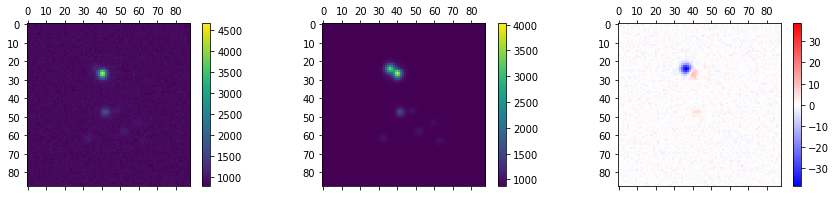

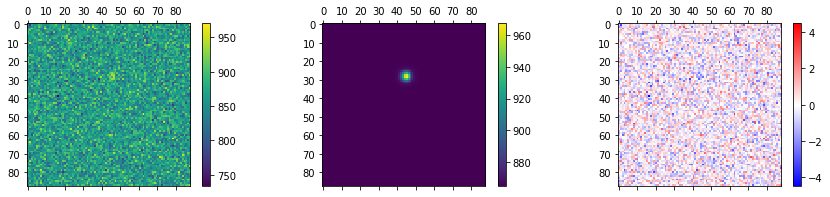

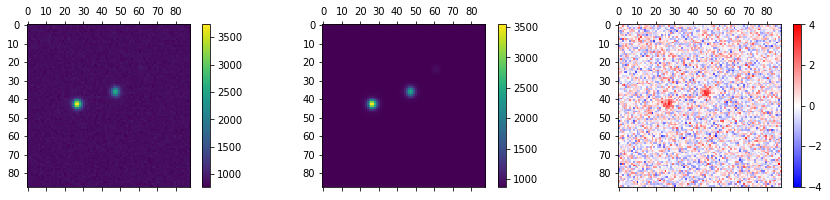

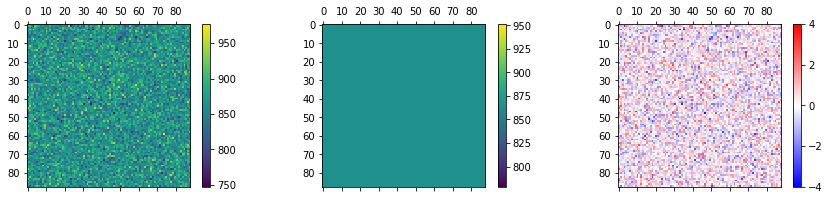

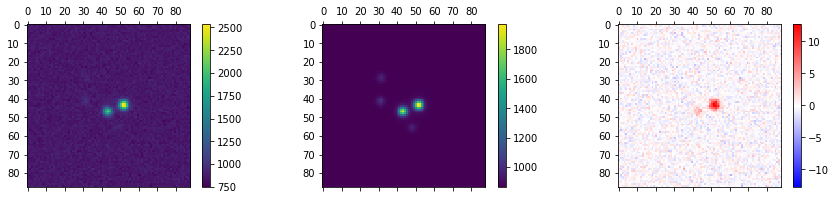

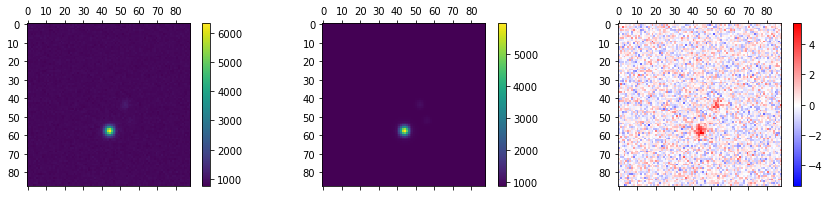

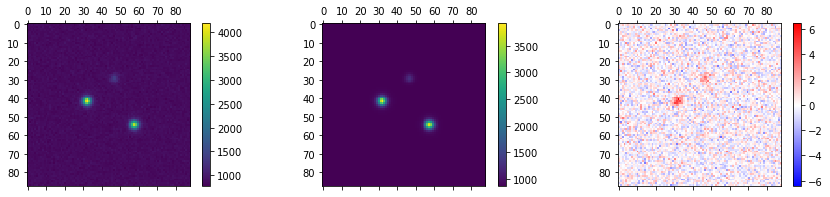

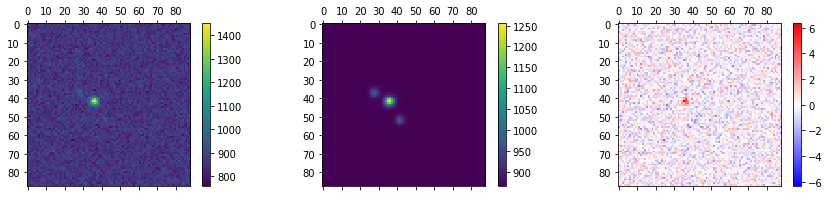

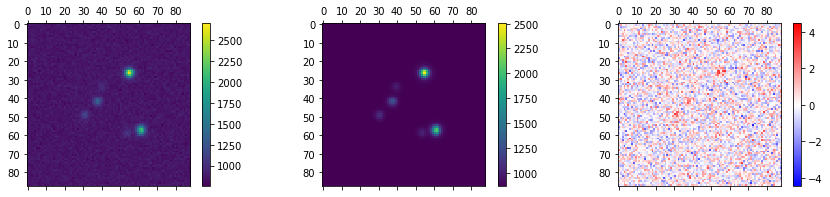

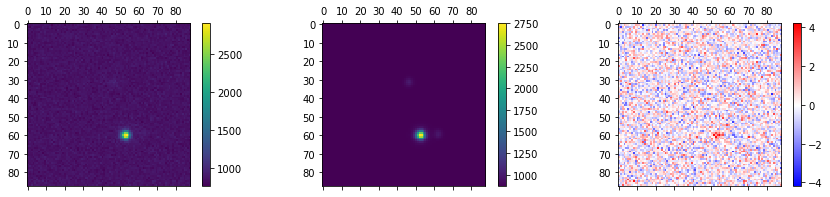

In [21]:
for indx in range(10):

    plotting_utils.plot_residuals(test_batch['images'][indx, 0], 
                                  recon[indx, 0], 
                                  resid_fun=lambda x, y : (x - y) / torch.sqrt(y))

In [22]:
is_star = get_star_bool(batch['n_sources'], batch['galaxy_bool']) == 1

truth = batch['fluxes'][is_star].cpu().numpy()
est = out['mean'][is_star].cpu().detach().numpy()

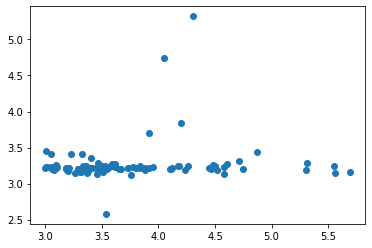

In [23]:
plt.scatter(np.log10(truth), 
            np.log10(est))

In [24]:
out['sd'][is_star].cpu().detach().numpy()

array([1099.1271 ,  332.01706,  274.7673 ,  254.22244,  282.84253,
        291.17358,  285.8072 ,  287.06625,  290.8997 ,  279.57083,
        281.87122,  293.94583,  277.01508,  277.66833,  280.03555,
        320.0169 ,  358.84302,  250.643  ,  314.3671 ,  277.13773,
        366.5364 ,  254.56612,  285.78516,  290.72232,  409.8226 ,
        286.59128,  280.18723,  272.9662 ,  300.70758,  354.81482,
        292.26816,  282.06607,  278.7483 ,  284.1908 ,  282.04117,
        282.2408 ,  281.61087,  279.8789 ,  276.45834,  285.35757,
        279.5372 ,  281.15448,  289.29285,  281.30017,  266.98505,
        280.22903,  283.95074,  296.4199 ,  274.6883 ,  292.6426 ,
        283.02444,  318.40305,  281.6878 ,  127.41215, 4271.8467 ,
        278.1209 ,  280.2017 ,  284.10162,  282.50128,  285.33792,
        288.5743 ,  281.04727,  293.8295 ,  281.8393 ,  274.2949 ,
        308.21472,  281.3516 ,  268.21658,  268.8507 ,  287.74347,
        294.4107 ,  281.46756,  286.25934,  275.74936,  288.84